In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from meshparty import skeleton, skeleton_io
import seaborn as sns
from cloudfiles import CloudFiles
import io
from meshparty import meshwork
import nglui 
from caveclient import CAVEclient
import skeleton_plot as skpl
import skeleton_plot.skel_io as skel_io


In [2]:
# pull out neurons that are proofread into a df
skeleton_manifest = pd.read_feather('/Users/emily.joyce/Work/helping_op/Olga/em_connectomics_mesh_skeletons_directory_proof_status.feather')
proofread_skels = skeleton_manifest[(~pd.isna(skeleton_manifest['status_dendrite'])) | (~pd.isna(skeleton_manifest['status_axon']))].reset_index()


In [3]:
#example google cloud paths 

#raw skeleton files
skel_path = 'https://storage.googleapis.com/allen-minnie-phase3/minniephase3-emily-pcg-skeletons/minnie_all/BIL_neurons/file_groups/'

# upright skeleton swcs
upright_path = 'https://storage.googleapis.com/allen-minnie-phase3/minniephase3-emily_skeleton_keys/upright/BIL_excitatory/'

# layer aligned
layer_aligned_path = 'https://storage.googleapis.com/allen-minnie-phase3/minniephase3-emily_skeleton_keys/layer_align/BIL_excitatory/'


# polygon files (layer bounds for each cell)
# gives 2d shape for each layer 
layer_bounds_path = 'https://storage.googleapis.com/allen-minnie-phase3/minniephase3-emily_skeleton_keys/poly_files/BIL_polys/'

# average layer bounds from IVSCC (to which layer aligned celled are alligned)
# this just gives a single value for each layer (straight line)
layer_bounds_average_path = "https://storage.googleapis.com/allen-minnie-phase3/minniephase3-emily_skeleton_keys/avg_layer_depths/"
avg_layers_fn = 'mouse_me_and_met_avg_layer_depths.json'





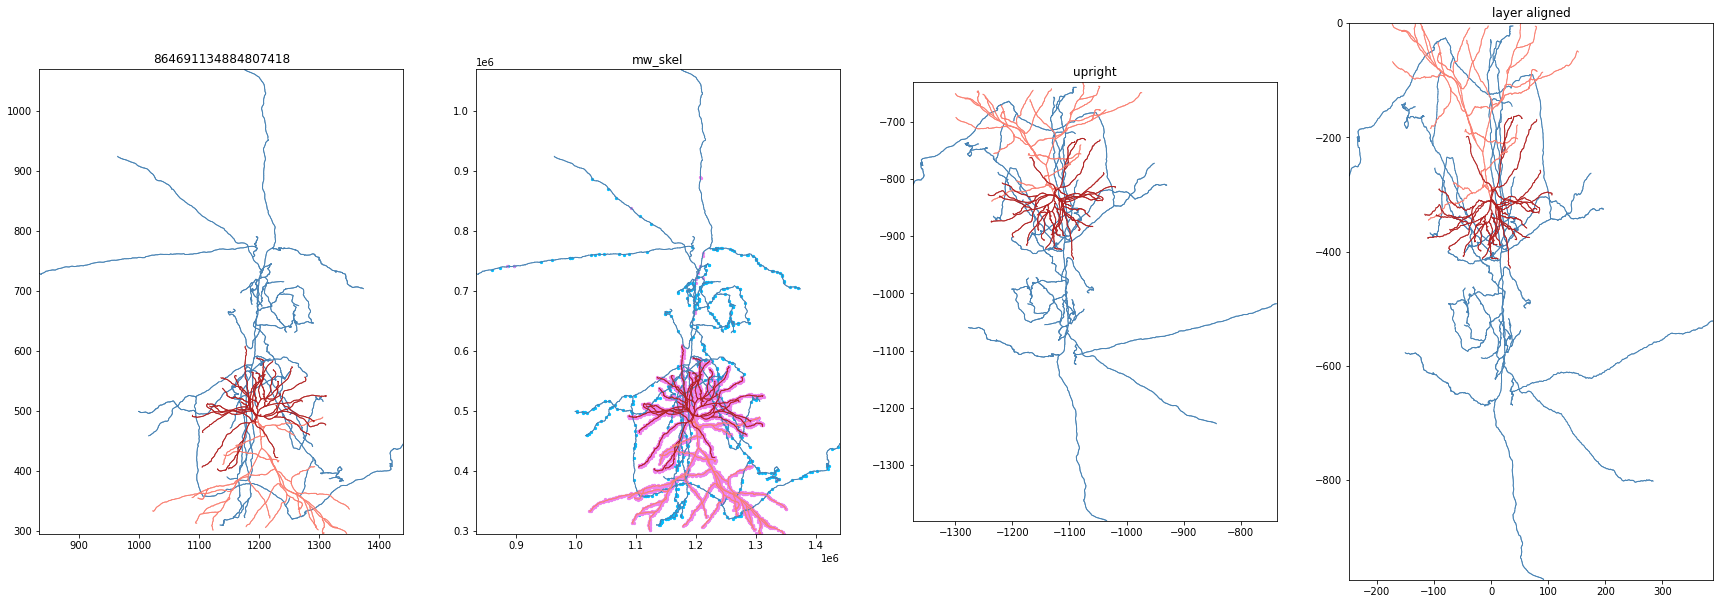

In [4]:
# Visuzlize the raw skeleton, skeleton from the meshwork with synapses, upright skeleton, layer aligned (broken) 

# visualize raw skeleton
f , ax = plt.subplots(1,4, figsize=(30,50))

row = 0

rid = proofread_skels.loc[row, 'root_id']
sid = proofread_skels.loc[row, 'soma_id']
folder = f'{skel_path}{rid}_{sid}'
filename = f'{rid}_{sid}.swc'
sk = skel_io.read_skeleton(folder, filename)

skpl.plot_tools.plot_skel(sk, title=rid, ax = ax[0], pull_compartment_colors=True)



# plot the skeleton with synapses from meshwork 
mw = skel_io.load_mw(folder, f'{rid}_{sid}.h5')
mw_skel = mw.skeleton
skpl.plot_tools.plot_mw_skel(mw, title = 'mw_skel', ax = ax[1], plot_presyn = True, plot_postsyn = True, 
                                pull_compartment_colors = True)

# visualize upright skel 
upright_skel = skel_io.read_skeleton(upright_path, f'{sid}.swc')
skpl.plot_tools.plot_skel(upright_skel, title = 'upright', ax = ax[2], pull_compartment_colors=True) 

# visualize layer aligned skel 
la_skel = skel_io.read_skeleton(layer_aligned_path, f'{sid}.swc')
skpl.plot_tools.plot_skel(la_skel, title = 'layer aligned', ax = ax[3], pull_compartment_colors=True) 


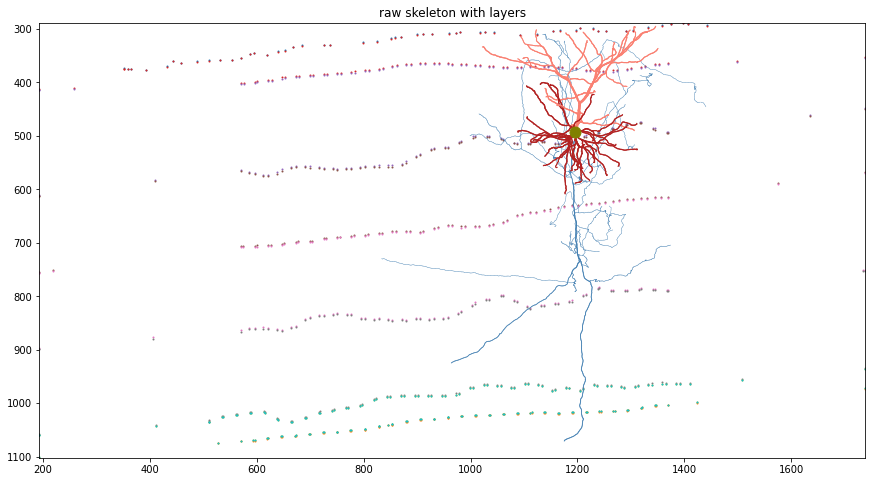

In [5]:
# plot the raw skeleton with layer bounds 
# layer 1, 2/3, 4, 5, 6a, 6b

poly_json = skel_io.read_json(layer_bounds_path, f'{sid}_poly.json')

f , ax = plt.subplots(figsize=(15,8))
skpl.plot_tools.plot_skel(sk, title='raw skeleton with layers', ax = ax, pull_compartment_colors = True, 
                          pull_radius=True, line_width=3.5, plot_soma=True)
skpl.plot_tools.plot_layer_poly(poly_json, ax = ax, invert_y = True)



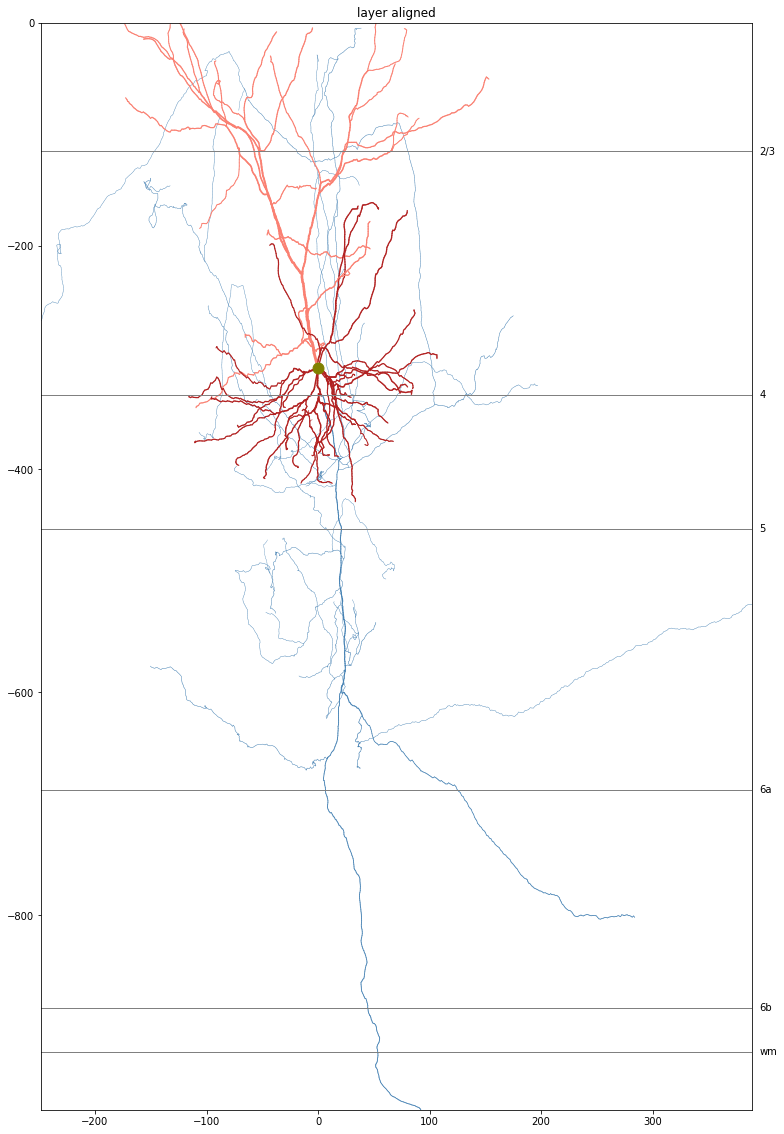

In [6]:
# plot the layer aligned cell with the average layer bounds plotted 
f , ax = plt.subplots(figsize=(15,20))
avg_layer_bounds = skel_io.read_json(layer_bounds_average_path, avg_layers_fn)
skpl.plot_tools.plot_skel(la_skel, title = 'layer aligned', ax = ax, pull_compartment_colors=True, 
                         pull_radius=True, line_width=3.5, plot_soma=True) 

skpl.plot_tools.plot_layer_lines(np.array(list(avg_layer_bounds.values()))*[-1], ax = ax, 
                                 labels = list(avg_layer_bounds.keys()),
                                    line_styles = {"color": "gray", "linewidth": 1, "linestyle": "-"})


In [7]:
# pull the neuron up in neuroglancer 

client = CAVEclient('minnie65_public_v343')

nglui.statebuilder.helpers.make_neuron_neuroglancer_link(client, rid)

# !! open this link in a new tab so that you don't lose this notebook 
# right click on hyperlink, new tab